# Education Attainment Prediction 2025
### Kaggle Competition

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [48]:
# Load data
census_raw = pd.read_csv("CENSUS_ED_ATTN.csv")

census_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151747 entries, 0 to 151746
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   A_MARITL   151747 non-null  int64
 1   A_SEX      151747 non-null  int64
 2   PEAFEVER   151747 non-null  int64
 3   PARENT     151747 non-null  int64
 4   PENATVTY   151747 non-null  int64
 5   PEFNTVTY   151747 non-null  int64
 6   PEHSPNON   151747 non-null  int64
 7   PEINUSYR   151747 non-null  int64
 8   PEPAR1TYP  151747 non-null  int64
 9   PRCITSHP   151747 non-null  int64
 10  PRDTRACE   151747 non-null  int64
 11  ERN_SRCE   151747 non-null  int64
 12  WSAL_VAL   151747 non-null  int64
 13  ANN_VAL    151747 non-null  int64
 14  A_HGA      151747 non-null  int64
dtypes: int64(15)
memory usage: 17.4 MB


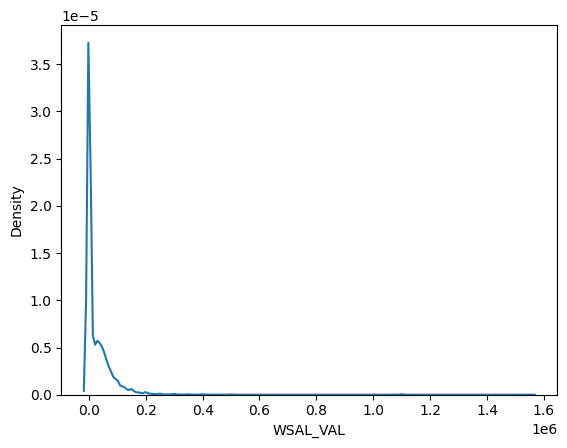

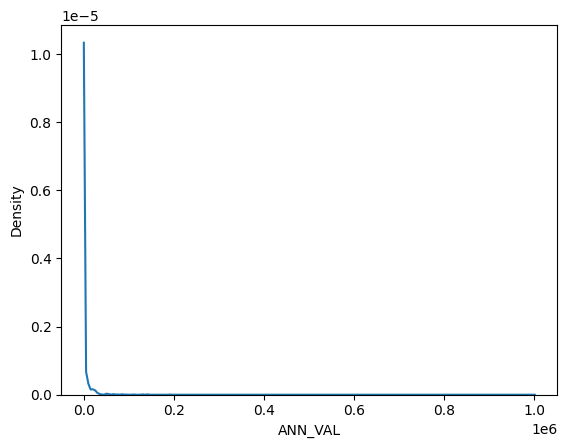

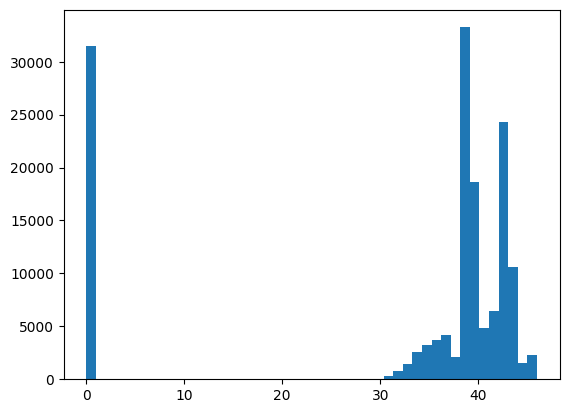

In [49]:
# Plot salary/wages
sns.kdeplot(census_raw['WSAL_VAL'])
plt.show()

# Plot other income
sns.kdeplot(census_raw['ANN_VAL'])
plt.show()

#plt.hist(census_raw['PEPAR1TYP'])
#plt.show()

# Plot target variable
plt.hist(census_raw['A_HGA'], bins=47)
plt.show()


#### Target Variable
Target Variable = `education`
0 | Child/incomplete secondary education
1 | High School Graduate
2 | Associate Degree
3 | Bachelor's Degree
4 | Master's Degree
5 | Professional/Doctorate Degree

Race dictionary
1 | White
2 | Black
3 | American Indian, Pacific Islander
4 | Asian
5 | Mixed

In [50]:
# Load data
census_raw = pd.read_csv("CENSUS_ED_ATTN.csv")

# Rename Columns
census = census_raw.rename(columns = {"PEAFEVER": "military_service", 
                                  "PARENT": 'parents',
                                  "PENATVTY": "birth_country",
                                  "PEFNTVTY": "father_country",
                                  "PEHSPNON": 'hispanic',
                                  "PEINUSYR": 'us_arrival',
                                  "PEPAR1TYP": 'parent1_status',
                                  "PRCITSHP": 'citizenship',
                                  "PRDTRACE": 'race',
                                  "ERN_SRCE": 'earnings_source',
                                  "A_MARITL": "marital_status",
                                  "A_SEX": 'sex'})

# Collapse Variables
census['marital_status'] = census.marital_status.apply(lambda x: 0 if x==7 else 1 if x in [1, 2, 3] else 2)
census['military_service'] = census.military_service.apply(lambda x: x if x==1 else 2)
census['us_arrival'] = census.us_arrival.apply(lambda x: x if x==0 else 1)
census['parent1_status'] = census.parent1_status.apply(lambda x: x if x==1 else 2)
census['race'] = census.race.apply(lambda x: x if x in [1, 2, 3, 4] else 3 if x==5 else 5)
census['earnings_source'] = census.earnings_source.apply(lambda x: x if x==1 else 2)

# Make a new column for aggregated income
census['income'] = census['WSAL_VAL'] + census['ANN_VAL']
census = census.drop(columns=['WSAL_VAL', 'ANN_VAL'])

# Encode categorical variables
categorical = ['marital_status', 'sex', 'military_service', 'parents', 'birth_country', 'father_country', 'hispanic', 'us_arrival', 'parent1_status', 'citizenship', 'race', 'earnings_source']
census[categorical] = census[categorical].astype('category')

# Collapse the target variable
no_ed = [0, 31, 32, 33, 34, 35, 36, 37, 38]
hs = [39, 40]
associate = [41, 42]
bachelors = [43]
masters = [44]
prof = [45, 46]

census['A_HGA'] = census.A_HGA.apply(lambda x: 0 if x in no_ed else 1 if x in hs else 2 if x in associate else 3 if x in bachelors else 4 if x in masters else 5).astype('category')
census = census.rename(columns={"A_HGA": "education"})


census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151747 entries, 0 to 151746
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   marital_status    151747 non-null  category
 1   sex               151747 non-null  category
 2   military_service  151747 non-null  category
 3   parents           151747 non-null  category
 4   birth_country     151747 non-null  category
 5   father_country    151747 non-null  category
 6   hispanic          151747 non-null  category
 7   us_arrival        151747 non-null  category
 8   parent1_status    151747 non-null  category
 9   citizenship       151747 non-null  category
 10  race              151747 non-null  category
 11  earnings_source   151747 non-null  category
 12  education         151747 non-null  category
 13  income            151747 non-null  int64   
dtypes: category(13), int64(1)
memory usage: 3.3 MB


In [51]:
# Define features and target
x = census.drop(columns='education')
y = census['education']

In [52]:
# Partition Data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=45)

In [53]:
# Instantiate k-fold object
kf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=45)

In [54]:
# Define Scoring Metrics
scorers = ['accuracy', 'precision', 'recall']

# Define hyperparameters
params = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [55]:
# Instantiate Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=45)

In [56]:
# Instantiate Grid Search on the DT
search = GridSearchCV(dt, param_grid=params, scoring=scorers, n_jobs=1, refit='accuracy', cv=kf)

In [57]:
# Employ the Grid Search
dt_model = search.fit(x_train, y_train)

/home/vscode/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py", line 2247, in precision_score
    p, _, _, _ = precision_rec

In [58]:
# Identify the best model
best = dt_model.best_estimator_
print(best)

DecisionTreeClassifier(max_depth=9, random_state=45)


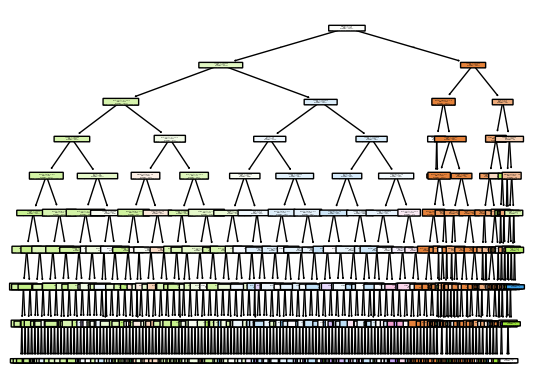

In [59]:
# Visualize the best model
plt.figure()
plot_tree(best, feature_names=x_train.columns, filled=True, rounded=True)
plt.show()

In [60]:
# Evaluate the performance metrics for the best model
best_index = dt_model.best_index_

# Extract Scores
accuracy = dt_model.cv_results_['mean_test_accuracy'][best_index]
recall = dt_model.cv_results_['mean_test_recall'][best_index]
precision = dt_model.cv_results_['mean_test_precision'][best_index]

score_df = pd.DataFrame({"Metric": ["Accuracy", "Recall", "Precision"],
                         "Score": [accuracy, recall, precision]})

print(score_df)


      Metric     Score
0   Accuracy  0.624052
1     Recall       NaN
2  Precision       NaN


In [61]:
# Determine Variable importance
var_importance = best.feature_importances_

var_importance_df = pd.DataFrame(var_importance, index=x_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

print(var_importance_df)

                  Importance
parents             0.796810
income              0.107177
birth_country       0.041711
marital_status      0.016854
sex                 0.015085
father_country      0.005985
citizenship         0.004768
race                0.003562
hispanic            0.003112
parent1_status      0.003085
military_service    0.000984
earnings_source     0.000785
us_arrival          0.000082
